# Dynamic Point Fields: Single Scan Animation Demo + Registration

This code will perform a single scan animation, as described in  [the original paper](https://arxiv.org/pdf/2304.02626.pdf) (Section 4.2-4.3).

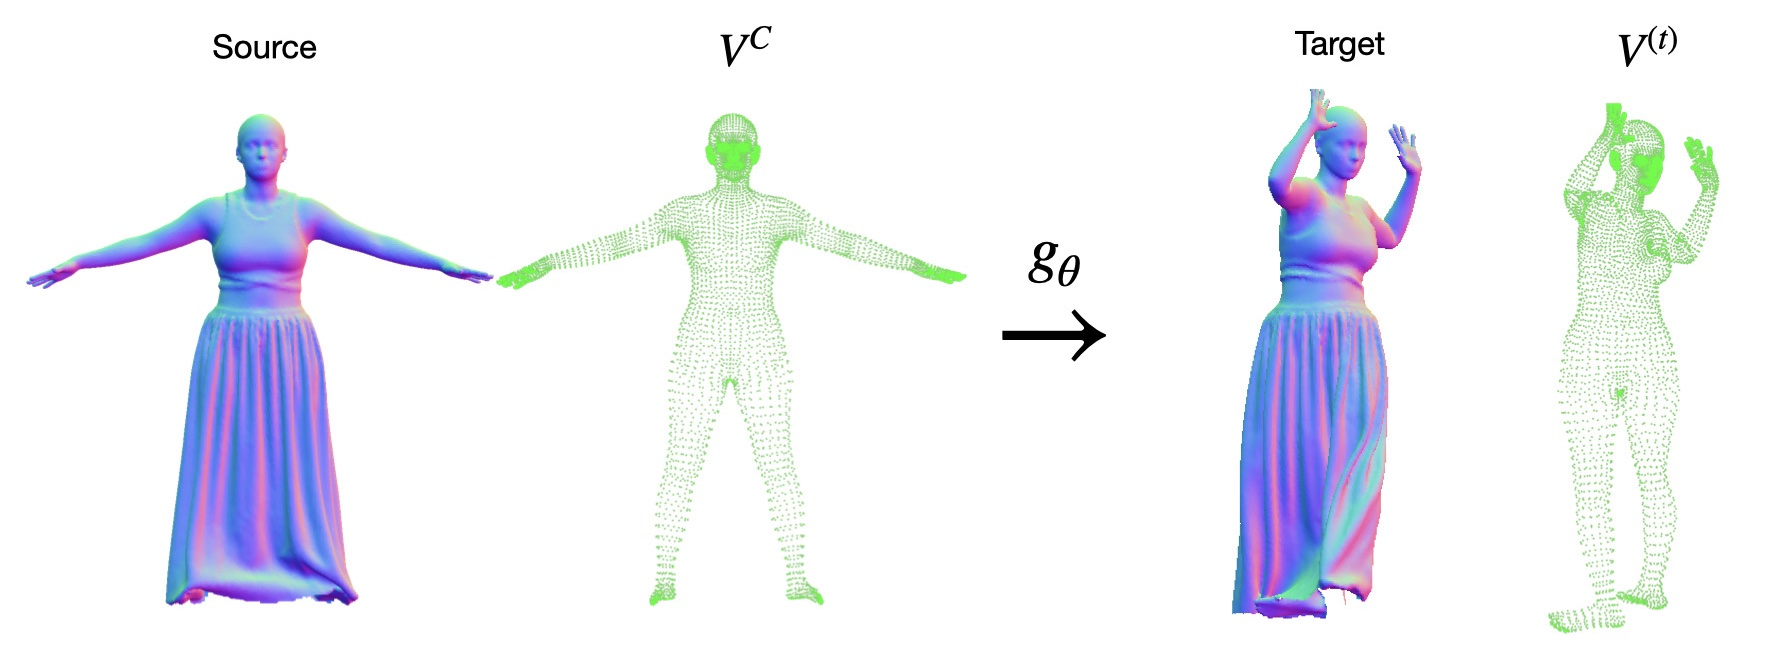

In [1]:
# @title Install dependencies (PyTorch3D, PyMeshlab, Open3d)
import sys
import torch

In [3]:
# @title Point rendering, saving clouds
import torch
from pytorch3d.structures import Pointclouds
from pytorch3d.vis.plotly_vis import AxisArgs, plot_batch_individually, plot_scene
from pytorch3d.renderer import (
    look_at_view_transform,
    FoVOrthographicCameras, 
    PerspectiveCameras,
    PointsRasterizationSettings,
    PulsarPointsRenderer,
    PointsRenderer,
    SfMPerspectiveCameras,
    PulsarPointsRenderer,
    PerspectiveCameras,
    PointsRasterizer,
    AlphaCompositor,
    NormWeightedCompositor
)
from pytorch3d.structures import Meshes

device = 'cuda'


def normalise_verts(V, V_scale=None, V_center=None):

  # Normalize mesh

  if V_scale is not None and V_center is not None:
    
    V = V - V_center
    V *= V_scale
  
  else:

    V_max, _ = torch.max(V, dim=0)
    V_min, _ = torch.min(V, dim=0)
    V_center = (V_max + V_min) / 2.
    V = V - V_center

    # Find the max distance to origin
    max_dist = torch.sqrt(torch.max(torch.sum(V**2, dim=-1)))
    V_scale = (1. / max_dist)
    V *= V_scale

  return V, V_scale, V_center


def normals_to_rgb(n):

  return torch.abs(n*0.5 + 0.5)
  
def get_point_renderer(image_size, radius=0.05, points_per_pixel=50):

  raster_settings = PointsRasterizationSettings(
      image_size=image_size, 
      radius = radius,
      points_per_pixel = points_per_pixel
      )

  rasterizer = PointsRasterizer(cameras=FoVOrthographicCameras(),
                                raster_settings=raster_settings)
  renderer = PointsRenderer(
      rasterizer=rasterizer,
      compositor=AlphaCompositor(background_color=(0, 0, 0, 0))
  )

  return renderer

def get_camera(dist=1, elev=0, azim=0):

  R, T = look_at_view_transform(dist=dist, elev=elev, azim=azim)

  cam = PerspectiveCameras(R=R, T=T)

  return cam

def render_points(x, xf, dist=1, elev=0, azim=0, image_size=512, radius=0.01, points_per_pixel=50, scale_val=1.0):

  x = x.to(device)
  xf = xf.to(device)
  renderer = get_point_renderer(image_size=image_size, radius=radius, points_per_pixel=points_per_pixel)
  R, T = look_at_view_transform(dist=dist, elev=elev, azim=azim)
  cam = FoVOrthographicCameras(R=R, T=T, scale_xyz=((scale_val, scale_val, scale_val),)).to(device)

  pcl = Pointclouds(points=x.unsqueeze(0), features=xf.unsqueeze(0)).to(device)

  img = renderer(pcl, cameras=cam)[0]

  return img

In [4]:
# @title Siren deformation model
from torch import nn
import numpy as np

class SineLayer(nn.Module):
    # See paper sec. 3.2, final paragraph, and supplement Sec. 1.5 for discussion of omega_0.
    
    # If is_first=True, omega_0 is a frequency factor which simply multiplies the activations before the 
    # nonlinearity. Different signals may require different omega_0 in the first layer - this is a 
    # hyperparameter.
    
    # If is_first=False, then the weights will be divided by omega_0 so as to keep the magnitude of 
    # activations constant, but boost gradients to the weight matrix (see supplement Sec. 1.5)
    
    def __init__(self, in_features, out_features, bias=True,
                 is_first=False, omega_0=30):
        super().__init__()
        self.omega_0 = omega_0
        self.is_first = is_first
        
        self.in_features = in_features
        self.linear = nn.Linear(in_features, out_features, bias=bias)
        
        self.init_weights()
    
    def init_weights(self):
        with torch.no_grad():
            if self.is_first:
                self.linear.weight.uniform_(-1 / self.in_features, 
                                             1 / self.in_features)      
            else:
                self.linear.weight.uniform_(-np.sqrt(6 / self.in_features) / self.omega_0, 
                                             np.sqrt(6 / self.in_features) / self.omega_0)
        
    def forward(self, input):
        return torch.sin(self.omega_0 * self.linear(input))
    
    def forward_with_intermediate(self, input): 
        # For visualization of activation distributions
        intermediate = self.omega_0 * self.linear(input)
        return torch.sin(intermediate), intermediate
    
    
class Siren(nn.Module):
    def __init__(self, in_features, hidden_features, hidden_layers, out_features, outermost_linear=False, 
                 first_omega_0=30, hidden_omega_0=30.):
        super().__init__()
        
        self.net = []
        self.net.append(SineLayer(in_features, hidden_features, 
                                  is_first=True, omega_0=first_omega_0))

        for i in range(hidden_layers):
            self.net.append(SineLayer(hidden_features, hidden_features, 
                                      is_first=False, omega_0=hidden_omega_0))

        if outermost_linear:
            final_linear = nn.Linear(hidden_features, out_features)
            
            with torch.no_grad():
                final_linear.weight.uniform_(-np.sqrt(6 / hidden_features) / hidden_omega_0, 
                                              np.sqrt(6 / hidden_features) / hidden_omega_0)
                
            self.net.append(final_linear)
        else:
            self.net.append(SineLayer(hidden_features, out_features, 
                                      is_first=False, omega_0=hidden_omega_0))
        
        self.net = nn.Sequential(*self.net)
    
    def forward(self, coords):
        coords = coords#.requires_grad_(True) # allows to take derivative w.r.t. input
        output = self.net(coords)
        return output #, coords

    def forward_with_activations(self, coords, retain_grad=False):
        '''Returns not only model output, but also intermediate activations.
        Only used for visualizing activations later!'''
        activations = OrderedDict()

        activation_count = 0
        x = coords.clone().detach().requires_grad_(True)
        activations['input'] = x
        for i, layer in enumerate(self.net):
            if isinstance(layer, SineLayer):
                x, intermed = layer.forward_with_intermediate(x)
                
                if retain_grad:
                    x.retain_grad()
                    intermed.retain_grad()
                    
                activations['_'.join((str(layer.__class__), "%d" % activation_count))] = intermed
                activation_count += 1
            else: 
                x = layer(x)
                
                if retain_grad:
                    x.retain_grad()
                    
            activations['_'.join((str(layer.__class__), "%d" % activation_count))] = x
            activation_count += 1

        return activations

In [5]:
# @title Deformation learning: main function
from tqdm import tqdm
import torch 
from pytorch3d.ops.knn import knn_points
from pytorch3d.loss.chamfer import chamfer_distance

device = 'cuda'

import torch
from torch.nn.functional import l1_loss

def isometric_loss(x_canonical, x_deformed, n_neighbors=5):
    """
    Computes the isometric loss between two sets of points, which measures the discrepancy
    between their pairwise distances.

    Parameters
    ----------
    x_canonical : array-like, shape (n_points, n_dims)
        The canonical (reference) point set, where `n_points` is the number of points
        and `n_dims` is the number of dimensions.
    x_deformed : array-like, shape (n_points, n_dims)
        The deformed (transformed) point set, which should have the same shape as `x_canonical`.
    n_neighbors : int, optional
        The number of nearest neighbors to use for computing pairwise distances.
        Default is 5.

    Returns
    -------
    loss : float
        The isometric loss between `x_canonical` and `x_deformed`, computed as the L1 norm
        of the difference between their pairwise distances. The loss is a scalar value.
    Raises
    ------
    ValueError
        If `x_canonical` and `x_deformed` have different shapes.
    """

    if x_canonical.shape != x_deformed.shape:
        raise ValueError("Input point sets must have the same shape.")

    _, nn_ix, _ = knn_points(x_canonical.unsqueeze(0), 
                             x_canonical.unsqueeze(0), 
                             K=n_neighbors, 
                             return_sorted=True)

    dists_canonical = torch.cdist(x_canonical[nn_ix], x_canonical[nn_ix])
    dists_deformed = torch.cdist(x_deformed[nn_ix], x_deformed[nn_ix])

    loss = l1_loss(dists_canonical, dists_deformed)

    return loss


# guided learning
def deform_cloud(model, xsrc, xtrg=None, vsrc=None, vtrg=None,
                 use_isometric=True, use_isometric_inter=True,
                 use_chamfer=True, use_guidance=True,
                 n_chamfer_samples=10**4, n_steps=20000, init_lr=1.0e-4,
                 isometric_weight=1.0e4, isometric_inter_max=1.0,
                 guided_weight=1.0e4, chamfer_weight=1.0e4,
                 iso_n_neighbors=5, eval_every_nth_step=100):
  """
  Deform a point cloud using a neural network model.

  Parameters
  ----------
  model : torch.nn.Module
      The neural network model to use for deformation.
  xsrc : numpy.ndarray
      The source point cloud to deform.
  xtrg : numpy.ndarray, optional
      The target point cloud to match (used in chamfer distance loss).
  vsrc : numpy.ndarray, optional
      The source keypoints to use as guidance for deformation.
  vtrg : numpy.ndarray, optional
      The target keypoints to match (used in guided loss).
  use_isometric : bool, optional
      Whether to use isometric loss (default is True).
  use_isometric_inter : bool, optional
      Whether to use isometric loss between halfway frames (default is True).
  use_chamfer : bool, optional
      Whether to use chamfer distance loss (default is True).
  use_guidance : bool, optional
      Whether to use guided loss (default is True).
  n_chamfer_samples : int, optional
      The number of points to sample for chamfer distance loss (default is 10**4).
  n_steps : int, optional
      The number of optimization steps (default is 20000).
  init_lr : float, optional
      The initial learning rate for the optimizer (default is 1.0e-4).
  isometric_weight : float, optional
      The weight for isometric loss (default is 1.0e4).
  isometric_inter_max : float, optional
      The interval for isometric loss between frames (default is 1.0). Check Section 3.2 for details
  guided_weight : float, optional
      The weight for guided loss (default is 1.0e4).
  chamfer_weight : float, optional
      The weight for chamfer distance loss (default is 1.0e4).
  iso_n_neighbors : int, optional
      The number of neighbors to use for isometric loss (default is 5).
  eval_every_nth_step : int, optional
      The number of steps between evaluations (default is 100).

  """


  model = model.train()
  l1_loss = torch.nn.L1Loss()
  optm = torch.optim.Adam(model.parameters(), lr=init_lr)
  schedm = torch.optim.lr_scheduler.ReduceLROnPlateau(optm, verbose=True, patience=1)

  if use_chamfer and xtrg is None:
    print("no target cloud provided, ignoring...")
    use_chamfer = False
  
  if use_guidance and vtrg is None:
    print("no keypoints provided, ignoring...")
    use_guidance = False

  guided_loss_total = 0  
  chamfer_loss_total = 0
  isometric_loss_total = 0
  total_loss = 0
  n_r = 0

  for i in range(0, n_steps):
    
    if use_isometric or use_chamfer or use_isometric_inter:
      xbatch_src = torch.Tensor(xsrc[np.random.choice(len(xsrc), n_chamfer_samples, replace=False)]).to(device)
      xbatch_deformed = xbatch_src + model(xbatch_src)

    if use_isometric_inter:
      # additionally enforce isometry between frames
      t = isometric_inter_max * np.random.uniform()
      xbatch_deformed_halfway = xbatch_src + isometric_inter_max*model(xbatch_src)

    loss = 0

    if use_isometric:
      iso_loss = isometric_weight*isometric_loss(xbatch_src, xbatch_deformed, n_neighbors=iso_n_neighbors)
      loss += iso_loss
      isometric_loss_total += float(iso_loss)

    if use_isometric_inter:
      iso_loss += isometric_weight*isometric_loss(xbatch_src, xbatch_deformed_halfway, n_neighbors=iso_n_neighbors)
      loss += iso_loss
      isometric_loss_total += float(iso_loss)

    if use_guidance:
      vsrc_deformed = vsrc + model(vsrc)
      guidance_loss = guided_weight*l1_loss(vsrc_deformed, vtrg)
      loss += guidance_loss
      guided_loss_total += float(guidance_loss)

    if use_chamfer:
      xbatch_trg = torch.Tensor(xtrg[np.random.choice(len(xtrg), n_chamfer_samples, replace=False)]).to(device)
      chamfer_loss = chamfer_weight*chamfer_distance(xbatch_deformed.unsqueeze(0), 
                                                     xbatch_trg.unsqueeze(0))[0]
      loss += chamfer_loss
      chamfer_loss_total += float(chamfer_loss)

    total_loss += float(loss)
    n_r += 1

    optm.zero_grad()
    loss.backward()
    optm.step()

    if i % eval_every_nth_step == 0:
      
      guided_loss_total /= n_r   
      isometric_loss_total /= n_r
      chamfer_loss_total /= n_r
      total_loss /= n_r

      schedm.step(float(total_loss))

      print("%05d tloss: %03f, guidl: %03f, chaml. :%03f, isol: %03f" 
            % (i, total_loss, guided_loss_total, chamfer_loss_total, isometric_loss_total))

      guided_loss_total = 0  
      chamfer_loss_total = 0
      isometric_loss_total = 0
      total_loss = 0
      n_r = 0
  
  guided_loss_total /= n_r   
  isometric_loss_total /= n_r
  chamfer_loss_total /= n_r
  total_loss /= n_r

  print("%05d tloss: %03f, guidl: %03f, chaml. :%03f, isol: %03f" 
            % (i, total_loss, guided_loss_total, chamfer_loss_total, isometric_loss_total))

  return 

In [224]:
import struct
def write_pointcloud(filename,xyz_points,rgb_points=None):

    """ creates a .pkl file of the point clouds generated
    """

    assert xyz_points.shape[1] == 3,'Input XYZ points should be Nx3 float array'
    if rgb_points is None:
        rgb_points = np.ones(xyz_points.shape).astype(np.uint8)*255
    assert xyz_points.shape == rgb_points.shape,'Input RGB colors should be Nx3 float array and have same size as input XYZ points'

    # Write header of .ply file
    fid = open(filename,'wb')
    fid.write(bytes('ply\n', 'utf-8'))
    fid.write(bytes('format binary_little_endian 1.0\n', 'utf-8'))
    fid.write(bytes('element vertex %d\n'%xyz_points.shape[0], 'utf-8'))
    fid.write(bytes('property float x\n', 'utf-8'))
    fid.write(bytes('property float y\n', 'utf-8'))
    fid.write(bytes('property float z\n', 'utf-8'))
    fid.write(bytes('property uchar red\n', 'utf-8'))
    fid.write(bytes('property uchar green\n', 'utf-8'))
    fid.write(bytes('property uchar blue\n', 'utf-8'))
    fid.write(bytes('end_header\n', 'utf-8'))

    # Write 3D points to .ply file
    for i in range(xyz_points.shape[0]):
        fid.write(bytearray(struct.pack("fffccc",xyz_points[i,0],xyz_points[i,1],xyz_points[i,2],
                                        rgb_points[i,0].tostring(),rgb_points[i,1].tostring(),
                                        rgb_points[i,2].tostring())))
    fid.close()

In [225]:
checkpoint = "./checkpoints/nerfsynth/human_cuda/200000_net_ray_marching.pth"
saved_features = torch.load(checkpoint, map_location=device)
point_cloud = saved_features["neural_points.xyz"]
write_pointcloud('./data_src/nerf/nerf_synthetic/human/pointcloud/67.ply', point_cloud.cpu().numpy())

/tmp/ipykernel_208498/1960734818.py:28: DeprecationWarning: tostring() is deprecated. Use tobytes() instead.
  rgb_points[i,0].tostring(),rgb_points[i,1].tostring(),
/tmp/ipykernel_208498/1960734818.py:29: DeprecationWarning: tostring() is deprecated. Use tobytes() instead.
  rgb_points[i,2].tostring())))


In [229]:
import point_cloud_utils as pcu
import numpy as np 
import torch
import matplotlib.pyplot as plt

device = 'cuda'

xsrc, csrc = pcu.load_mesh_vc('./data_src/nerf/nerf_synthetic/human/pointcloud/67.ply')
# xtrg, ctrg = pcu.load_mesh_vc('./dpf_demo_data/target_scan.ply')

vsrc = pcu.load_mesh_v('./data_src/nerf/nerf_synthetic/human/keypoint/67.obj')
vtrg = pcu.load_mesh_v('./data_src/nerf/nerf_synthetic/human/keypoint/97.obj')

xsrc = torch.Tensor(xsrc).to(device)
csrc = torch.Tensor(csrc/255).to(device)
xtrg = torch.Tensor(xtrg).to(device)
ctrg = torch.Tensor(ctrg/255).to(device)

vsrc = torch.Tensor(vsrc).to(device)[48:]
vtrg = torch.Tensor(vtrg).to(device)[48:]

# define colors for verts
vrgb = torch.zeros([len(vsrc), 4]).to(device)
vrgb[:, 1] = 1
vrgb[:, 3] = 1

In [230]:
xsrc_x, xsrc_y, xsrc_z = xsrc[:, 0], xsrc[:, 1], xsrc[:, 2]
xsrc = torch.stack([xsrc_x, xsrc_z, -xsrc_y], dim = -1)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


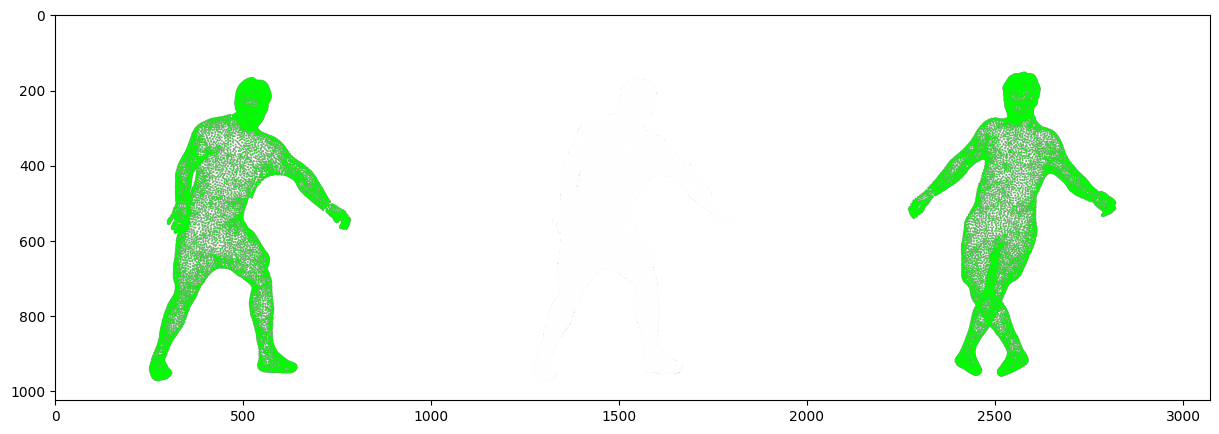

In [231]:
# let's render our source and target scans

yxsrc = render_points(xsrc, csrc, azim=0, radius=0.005, image_size=1024).detach().cpu().numpy()
yvsrc = render_points(vsrc, vrgb, azim=0, radius=0.005, image_size=1024).detach().cpu().numpy()
yvtrg = render_points(vtrg, vrgb, azim=0, radius=0.005, image_size=1024).detach().cpu().numpy()

y = np.hstack([yvsrc, yxsrc, yvtrg])

plt.figure(figsize=(20, 5))
plt.imshow(y)

In [232]:
# main loop #1: define a model and run deformation, WITHOUT the ground truth scan supervision

model = Siren(in_features=3, 
                hidden_features=128, 
                hidden_layers=3, 
                out_features=3, outermost_linear=True,
                first_omega_0=30, hidden_omega_0=30.).to(device).train()

deform_cloud(model, 
             xsrc=xsrc, vsrc=vsrc, vtrg=vtrg, 
             init_lr=1.0e-4, 
             n_steps=2000,
             use_chamfer=False, 
             use_guidance=True,
             use_isometric=True,
             guided_weight=1.0e4,
             isometric_weight=1.0e3)

00000 tloss: 1111.225220, guidl: 1104.930908, chaml. :0.000000, isol: 6.294271
00100 tloss: 113.841138, guidl: 108.957026, chaml. :0.000000, isol: 4.884111
00200 tloss: 24.544556, guidl: 21.563448, chaml. :0.000000, isol: 2.981108
00300 tloss: 20.995686, guidl: 18.323449, chaml. :0.000000, isol: 2.672237
00400 tloss: 18.082296, guidl: 15.547319, chaml. :0.000000, isol: 2.534977
00500 tloss: 17.902160, guidl: 15.448569, chaml. :0.000000, isol: 2.453591
00600 tloss: 16.538585, guidl: 14.138912, chaml. :0.000000, isol: 2.399673
00700 tloss: 16.431410, guidl: 14.074331, chaml. :0.000000, isol: 2.357079
00800 tloss: 15.327274, guidl: 13.003729, chaml. :0.000000, isol: 2.323545
00900 tloss: 14.809621, guidl: 12.515978, chaml. :0.000000, isol: 2.293644
01000 tloss: 13.716059, guidl: 11.446861, chaml. :0.000000, isol: 2.269198
01100 tloss: 12.938137, guidl: 10.690381, chaml. :0.000000, isol: 2.247755
01200 tloss: 12.920555, guidl: 10.691154, chaml. :0.000000, isol: 2.229400
01300 tloss: 13.215

In [233]:
# let's render the results
model.eval()
xpred = xsrc + model(xsrc).detach().clone()
xpred = torch.Tensor(xpred).to(device)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


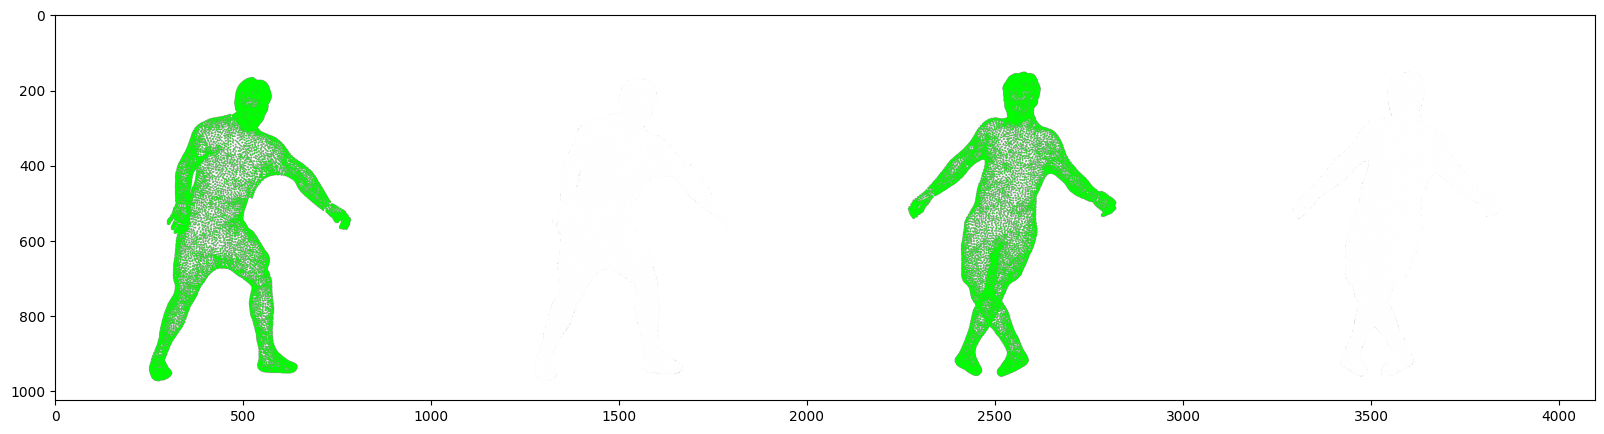

In [234]:
# let's render our source and target scans

yxsrc = render_points(xsrc, csrc, azim=0, radius=0.005, image_size=1024).detach().cpu().numpy()
yxtrg = render_points(xpred, csrc, azim=0, radius=0.005, image_size=1024).detach().cpu().numpy()
yvsrc = render_points(vsrc, vrgb, azim=0, radius=0.005, image_size=1024).detach().cpu().numpy()
yvtrg = render_points(vtrg, vrgb, azim=0, radius=0.005, image_size=1024).detach().cpu().numpy()

y = np.hstack([yvsrc, yxsrc, yvtrg, yxtrg])

plt.figure(figsize=(20, 5))
plt.imshow(y)

In [235]:
xsrc_x, xsrc_y, xsrc_z = xpred[:, 0], xpred[:, 1], xpred[:, 2]
xpred = torch.stack([xsrc_x, -xsrc_z, xsrc_y], dim = -1)

In [236]:
write_pointcloud('./data_src/nerf/nerf_synthetic/human/pointcloud/97.ply', xpred.cpu().numpy())
saved_features["neural_points.xyz"] = xpred
torch.save(saved_features, checkpoint)

/tmp/ipykernel_208498/1960734818.py:28: DeprecationWarning: tostring() is deprecated. Use tobytes() instead.
  rgb_points[i,0].tostring(),rgb_points[i,1].tostring(),
/tmp/ipykernel_208498/1960734818.py:29: DeprecationWarning: tostring() is deprecated. Use tobytes() instead.
  rgb_points[i,2].tostring())))
